# Featurize processed data

In [1]:
repo_path = "/Users/johnzhou/research/decision-making"

## Import packages

In [2]:
import sys
sys.path.append(repo_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
import torch

from src.data.experiment_data import ExperimentData
from src.features.build_features import normalize_features
from src.models.sigmoidnet import SigmoidNet
from src.models.train import train

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1000, 3) (1000,) (1000, 15)
(1000, 3)
500.0
(1000, 3)


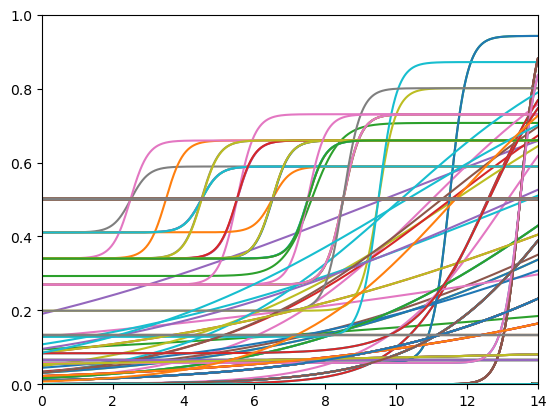

In [17]:
expt_name = "test_short"
bigboy = ExperimentData(expt_name, repo_path)
print(bigboy.sigmoid_parameters.shape, bigboy.foraging_efficiency.shape, bigboy.choice_blocks.shape)
a = bigboy.build_modeling_feats(include_feff=False, include_block=False)
np.sum(np.isnan(a))
print(np.sum(bigboy.agent_labels))
# a = plt.hist([bigboy.sigmoid_parameters[:500, 2], bigboy.sigmoid_parameters[500:, 2]], bins=30)
bigboy.visualize_sigmoids(range(0,1000))

In [20]:
from sklearn.manifold import TSNE
X_embedded_mse = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(bigboy.sigmoid_parameters)

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


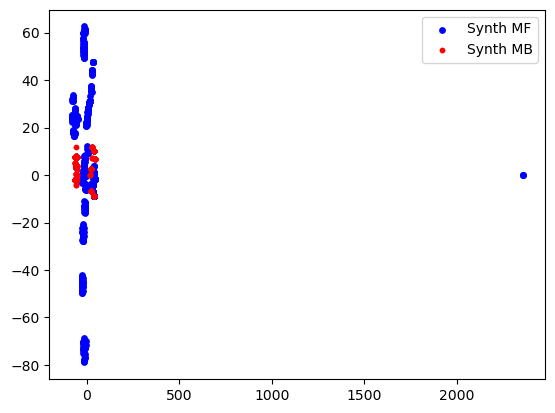

In [22]:
plt.figure()
mse_boundary = 500

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=15)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

plt.show()

Sigmoid fitting with MSE loss seems to be empirically more sensitive.

In [13]:
config = OmegaConf.create({
    "name": expt_name,
    "random_seed": 4995,
    "model": {
        "in_features": 3,
        "linear_layers": [32, 8, 4],
        "use_batch_norm": False
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{bigboy.data_path}/modeling_features.npy",
        "label_path": f"{bigboy.data_path}/agent_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 128,
        "val_batch_size": 128
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 1000
    },

})

OmegaConf.save(config=config, f=f"{repo_path}/configs/model_configs/sigmoidnet_train.yaml")

In [6]:
%reload_ext tensorboard
%tensorboard --logdir=$bigboy.data_path/lightning_logs

In [14]:
system, trainer = train(
    SigmoidNet,
    OmegaConf.to_container(config),
    experiment_dir=bigboy.data_path,
    checkpoint_name="model")

Global seed set to 4995


LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/johnzhou/research/decision-making/data/processed/test_short/test_short/lightning_logs

  | Name  | Type           | Params
-----------------------------------------
0 | loss  | SupConLoss     | 0     
1 | model | LinearEmbedder | 438   
-----------------------------------------
438       Trainable params
0         Non-trainable params
438       Total params
0.002     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                 | 0/2 [00:00<?, ?it/s]

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|                                                      | 0/9 [00:00<?, ?it/s]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████| 9/9 [00:00<00:00, 87.70it/s, loss=nan, v_num=0, val_loss=nan.0]
Epoch 0: 100%|█| 9/9 [00:00<00:00, 57.61it/s, loss=nan, v_num=0, val_loss=nan.0, train_los


In [8]:
X_fname = f"{data_dir}/processed/{expt_name}/synth_feats.npy"
model_fname = f"{expt_dir}/linear2D/model-v13.ckpt"
system = SigmoidNet(config)

model = system.load_from_checkpoint(model_fname)

NameError: name 'data_dir' is not defined

0.9 prew

In [ ]:
X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 3995

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

border = -0.027
plt.hlines(border, -.55, -.2)

plt.show()

In [ ]:

print("% of MF that are over:", np.sum(X_embedded_mse[:mse_boundary, 1] > border) / X_embedded_mse[:mse_boundary, 1].size)
print("% of MB that are under:", np.sum(X_embedded_mse[mse_boundary:, 1] < border) / X_embedded_mse[mse_boundary:, 1].size)

print("% of over that are MF:",np.sum(X_embedded_mse[:mse_boundary, 1] > border) / np.sum(X_embedded_mse[:, 1] > border))
print("% of under that are MB:",np.sum(X_embedded_mse[mse_boundary:, 1] < border) / np.sum(X_embedded_mse[:, 1] < border))



1.0 prew

In [ ]:
X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 42171

# X_embedded_mse = normalize_features(X_embedded_mse)

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(X_embedded_mse[mse_boundary1:, 0], X_embedded_mse[mse_boundary1:, 1], color='yellow', s=5)

borders = [-0.585, -0.57, -0.555, -0.51, -0.45, -0.35, -0.277]
plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')
plt.vlines(borders, -0.6, 0, color='black')

plt.show()

In [ ]:
print("% of MF that are left:", np.sum(X_embedded_mse[:mse_boundary, 0] < border) / X_embedded_mse[:mse_boundary, 0].size)
print("% of MB that are right:", np.sum(X_embedded_mse[mse_boundary:, 0] > border) / X_embedded_mse[mse_boundary:, 0].size)

print("% of left that are MF:",np.sum(X_embedded_mse[:mse_boundary, 0] < border) / np.sum(X_embedded_mse[:, 0] < border))
print("% of right that are MB:",np.sum(X_embedded_mse[mse_boundary:, 0] > border) / np.sum(X_embedded_mse[:, 0] > border))




In [ ]:
plt.figure()
mse_boundary = 42171

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=15)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(X_embedded_mse[mse_boundary1:, 0], X_embedded_mse[mse_boundary1:, 1], color='yellow', s=5)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

plt.show()